# Solving the MECP with QAOA+ using "Random Parameters" technique 

## Import Modules & Define Functions

In [12]:
from __future__ import annotations
from utils_to_build_QAOAAnsatz import *

In [13]:
from datetime import datetime
import math 
import random
import time

from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.primitives import StatevectorEstimator, StatevectorSampler
from scipy.optimize import minimize
from pprint import pprint # to print dictionaries

In [14]:
def write_params_on_file(DATA_FILE, params):
    DATA_FILE.write("\nChosen parameters:\n")
    DATA_FILE.write(f"Number of layers (p): {params['p']}\n")
    DATA_FILE.write(f"Number of random attempts: {params['random_attempts']}\n")
    DATA_FILE.write(f"Initialization type: {params['init_string']}\n")
    DATA_FILE.write(f"Size (n): {params['n']}\n")
    DATA_FILE.write(f"Chosen instances (chosen_instances): {params['chosen_instances']}\n")
    DATA_FILE.write(f"Choice of k (chosen_k): {params['chosen_k']}\n")

    
    # Display the chosen parameters
    print(f"######### ...Writing on file...: #########")
    print("Chosen parameters:")
    print(f"Number of layers (p): {params['p']}")
    print(f"Number of random attempts: {params['random_attempts']}")
    print(f"Initialization type: {params['init_string']}")
    print(f"Size (n): {params['n']}")
    print(f"Chosen instances (chosen_instances): {params['chosen_instances']}")
    print(f"Choice of k (chosen_k): {params['chosen_k']}")
    print(f"##########################################")

## Set Parameters

In [15]:
# Get parameters from the user
params = get_parameters_from_user()

# Get the parameters separately
chosen_instances = params['chosen_instances']
chosen_k = params['chosen_k']
p = params['p']
random_attempts = params['random_attempts']
init_string = params['init_string']
n = params['n']

Number of layers (p), default is 3:  
Number of random attempts, default is 20:  
String initialization (all1 or all0), default is 'all1':  
Size n (6, 8, 10), default is 6:  
Number or list of numbers from 1 to 10 for chosen instances, default is [1, ..., 10]:  1,2
Choice for 'chosen_k' (1, 'L=n', 'L=max(L_EC)', 'L=L_MEC'), default is 'L=L_MEC':  


In [16]:
# This is computed in QAOA_k.ipynb
k_dict = {'L=L_MEC': [0.167,0.167,0.167,0.112,0.167,0.167,0.25,0.167,0.084,0.084],
         'L=max(L_EC)': [0.167,0.167,0.25,0.167,0.334,0.25,0.25,0.167,0.084,0.084],
         'L=n': [0.334, 0.5, 0.5, 0.334, 0.5, 0.5, 0.5, 0.334, 0.25, 0.25]}

## For Every Instance Chosen, Do the Minimization
This code iterates through selected instances, generating corresponding subsets and computing the spectrum of states, including Minimum Exact Cover (MEC) states. It then builds the quantum circuits for the QAOA+ algorithm, including cost, mixing, and initialization circuits. Initial angles (betas and gammas) are randomly set within specified bounds, and the QAOA+ algorithm is run for multiple random initializations to minimize energy. Results, such as the optimal parameters, best attempt, minimum energy, and elapsed time, are recorded. Final data of each instance is saved in a .csv and a .txt.



**************************************************
Instance 1 with h = 0.167



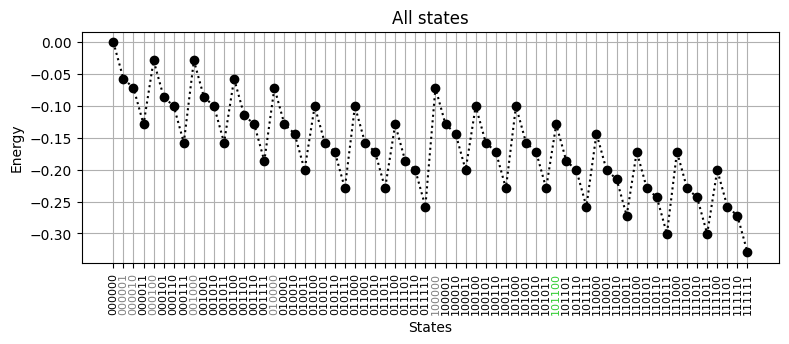

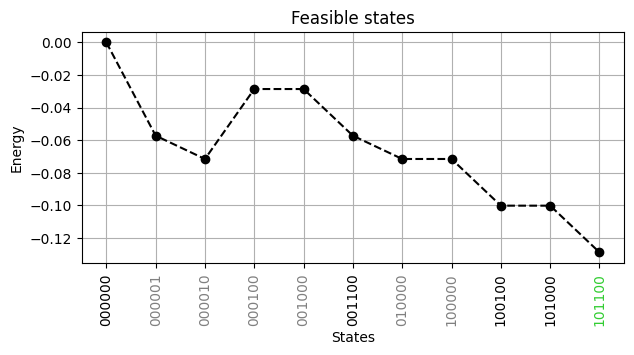

[{8, 1, 12}, {2, 3, 5}, {2, 6, 7, 9, 12}, {4, 6, 7, 9, 10, 11}, {1, 2, 5, 6, 11, 12}, {1, 3, 4, 5, 9, 12}]
######### ...Writing on file...: #########
Chosen parameters:
Number of layers (p): 3
Number of random attempts: 20
Initialization type: all1
Size (n): 6
Chosen instances (chosen_instances): [1, 2]
Choice of k (chosen_k): L=L_MEC
##########################################

---------- 1/20 random_attempts -----------

pars_0 = [1.9826474899818105, 1.5219792568688457, 0.7451852628241876, -49.81059305761019, 41.6672489319202, -33.44598993837255]
bnds = [(0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (-110, 110), (-110, 110), (-110, 110)]

Optimization terminated successfully.
         Current function value: 0.052672
         Iterations: 365
         Function evaluations: 582
E_min = result.fun + constant = -0.11202755378519398
E_min = result.fun = 0.05267244621480603

Optimal parameters: betas, gammas = [1.3212301853579285, 2.9982542520118267, 0.553662022399

/tmp/ipykernel_349/189524583.py:115: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  result = minimize(cost_func, # change cost_func -> cost_func_plot to plot iterations


E_min = result.fun + constant = -0.10503665452691759
E_min = result.fun = 0.05966334547308243

Optimal parameters: betas, gammas = [1.2545633001247438, 2.8545716334593516, 4.468493977943863], [-109.99999998911977, 22.081762395734366, 51.33732678168032]
--> ***NOT UPDATING THE BEST ATTEMPT***


---------- 5/20 random_attempts -----------

pars_0 = [1.9393876966876362, 4.870197884984919, 3.4348444869213273, -8.376121235797967, -48.80785585965972, -42.0379533420449]
bnds = [(0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (-110, 110), (-110, 110), (-110, 110)]



/tmp/ipykernel_349/189524583.py:115: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  result = minimize(cost_func, # change cost_func -> cost_func_plot to plot iterations


E_min = result.fun + constant = -0.10789614604883546
E_min = result.fun = 0.05680385395116455

Optimal parameters: betas, gammas = [1.032219720363449, 6.009500299519992, 2.4315211110143715], [-26.3238573138455, 6.4489894056505355, -75.29542933686213]
--> ***NOT UPDATING THE BEST ATTEMPT***


---------- 6/20 random_attempts -----------

pars_0 = [2.3302598918786503, 1.7262919631261144, 1.8313594743146382, 0.7525188688810971, -49.286112932955476, -65.24178071729894]
bnds = [(0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (-110, 110), (-110, 110), (-110, 110)]



/tmp/ipykernel_349/189524583.py:115: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  result = minimize(cost_func, # change cost_func -> cost_func_plot to plot iterations


E_min = result.fun + constant = -0.12095326693939097
E_min = result.fun = 0.04374673306060904

Optimal parameters: betas, gammas = [2.829792638201199, 2.869642600362053, 4.626643410266627], [0.5551141115626895, -87.34201474122409, -86.0220147507168]
--> ***UPDATING THE BEST ATTEMPT***


---------- 7/20 random_attempts -----------

pars_0 = [0.3753451868255316, 3.690024518401966, 2.0335275281270224, 51.755672298930534, -45.66602665066041, -101.14172695593402]
bnds = [(0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (-110, 110), (-110, 110), (-110, 110)]

Optimization terminated successfully.
         Current function value: 0.052406
         Iterations: 347
         Function evaluations: 549
E_min = result.fun + constant = -0.11229386829432791
E_min = result.fun = 0.05240613170567209

Optimal parameters: betas, gammas = [1.3066074349870647, 3.3167002832004355, 0.5645519661926046], [6.736841496640087, -20.17662470987179, -110.0]
--> ***NOT UPDATING THE BEST ATTEMPT

/tmp/ipykernel_349/189524583.py:115: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  result = minimize(cost_func, # change cost_func -> cost_func_plot to plot iterations


E_min = result.fun + constant = -0.11467118027600409
E_min = result.fun = 0.05002881972399592

Optimal parameters: betas, gammas = [5.219155675546016, 1.3831749928973265, 3.9515034126638335], [46.4234108337625, 18.737280193310752, 70.32346386980505]
--> ***NOT UPDATING THE BEST ATTEMPT***


---------- 11/20 random_attempts -----------

pars_0 = [0.938679141855778, 0.40234757483217387, 0.23064386588196456, 53.97786920973269, -45.88265349232503, -2.5239156819343975]
bnds = [(0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (-110, 110), (-110, 110), (-110, 110)]

Optimization terminated successfully.
         Current function value: 0.057573
         Iterations: 593
         Function evaluations: 925
E_min = result.fun + constant = -0.10712657624314079
E_min = result.fun = 0.05757342375685922

Optimal parameters: betas, gammas = [1.2292335685095623, 3.074445071159313, 0.3105155267265104], [0.9849219582660901, 14.29344241207326, 13.86960790703161]
--> ***NOT UPDATING 

/tmp/ipykernel_349/189524583.py:115: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  result = minimize(cost_func, # change cost_func -> cost_func_plot to plot iterations


E_min = result.fun + constant = -0.09643670147762395
E_min = result.fun = 0.06826329852237606

Optimal parameters: betas, gammas = [1.0862727435552316e-11, 4.813689600114067, 3.846716732744042], [109.836097226486, 109.63643588718418, -1.3479431684727648e-06]
--> ***NOT UPDATING THE BEST ATTEMPT***


---------- 15/20 random_attempts -----------

pars_0 = [3.038617195332501, 2.8351411219162395, 0.008600737255646378, 101.19129328724625, -2.59236570964633, 105.37537741651187]
bnds = [(0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (-110, 110), (-110, 110), (-110, 110)]

Optimization terminated successfully.
         Current function value: 0.058974
         Iterations: 577
         Function evaluations: 930
E_min = result.fun + constant = -0.10572572194475413
E_min = result.fun = 0.05897427805524588

Optimal parameters: betas, gammas = [1.2776314424832864, 3.2918706798929804, 0.0], [-3.498039022266921, -88.0590462291872, -110.0]
--> ***NOT UPDATING THE BEST ATTEMPT*

/tmp/ipykernel_349/189524583.py:115: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  result = minimize(cost_func, # change cost_func -> cost_func_plot to plot iterations


E_min = result.fun + constant = -0.10671062856470692
E_min = result.fun = 0.057989371435293084

Optimal parameters: betas, gammas = [1.1506984103178013, 3.5869143502248875, 4.667688297019792], [109.99740674047575, 66.93932039089384, 40.30658895088327]
--> ***NOT UPDATING THE BEST ATTEMPT***


---------- 17/20 random_attempts -----------

pars_0 = [0.8433884095947797, 0.8302691938604296, 6.1554853790865, -50.133084049683205, 3.404012428258909, -2.5644282605241955]
bnds = [(0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (-110, 110), (-110, 110), (-110, 110)]

Optimization terminated successfully.
         Current function value: 0.059015
         Iterations: 551
         Function evaluations: 851
E_min = result.fun + constant = -0.10568530908491669
E_min = result.fun = 0.05901469091508332

Optimal parameters: betas, gammas = [1.223813424793372, 3.237935729330734, 6.2831853071789965], [-5.290943022599952e-06, 2.7973707119496066e-05, 7.474301669470128]
--> ***NOT UP

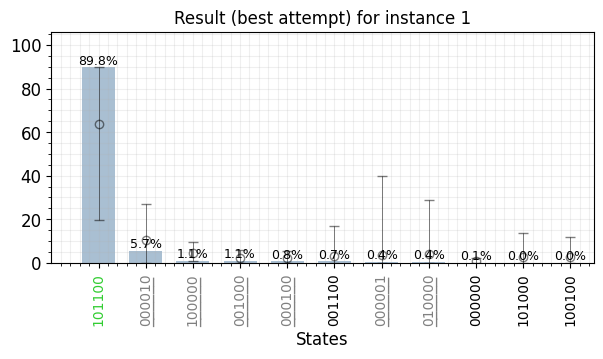

Result saved in:
random_parameters_2025-01-30@09h03m50s/dim6_mail1_all1_random_p3_20ra_k0.167_BOUNDS[0,2pi]x[-110,110]_pars0[0,2pi]x[-110,110].csv
random_parameters_2025-01-30@09h03m50s/dim6_mail1_all1_random_p3_20ra_k0.167_BOUNDS[0,2pi]x[-110,110]_pars0[0,2pi]x[-110,110]_data.txt

TOTAL ELAPSED TIME: 23.466650025049844 minutes.
**************************************************
Instance 2 with h = 0.167



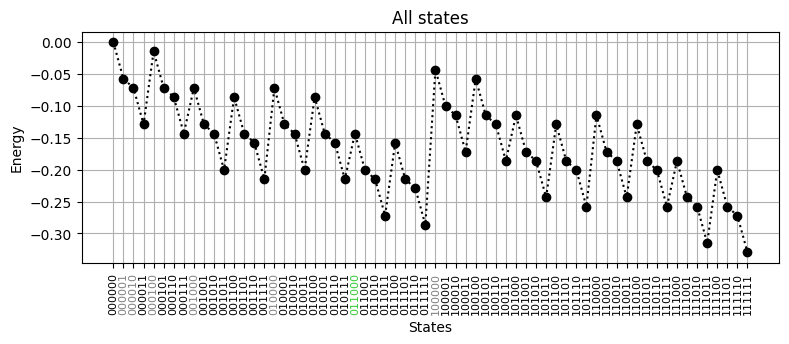

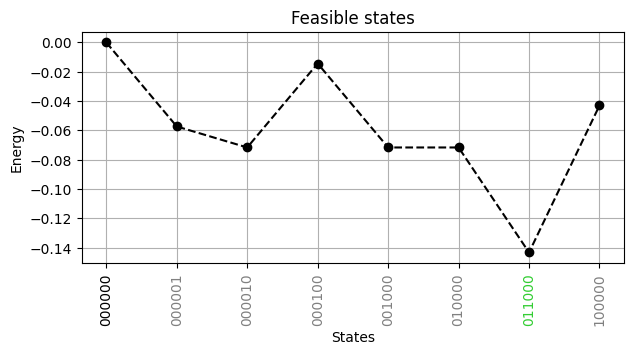

[{2, 7}, {2, 11, 12, 6}, {1, 2, 8, 9, 12}, {2, 4, 6, 8, 9, 11}, {1, 3, 5, 7, 10, 12}, {2, 3, 4, 5, 8, 12}]
######### ...Writing on file...: #########
Chosen parameters:
Number of layers (p): 3
Number of random attempts: 20
Initialization type: all1
Size (n): 6
Chosen instances (chosen_instances): [1, 2]
Choice of k (chosen_k): L=L_MEC
##########################################

---------- 1/20 random_attempts -----------

pars_0 = [4.484816751568494, 0.5967457002544646, 5.489178784464775, -131.8030293026226, -145.9542770741146, 73.55707867617292]
bnds = [(0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (-220, 220), (-220, 220), (-220, 220)]

Optimization terminated successfully.
         Current function value: 0.052989
         Iterations: 592
         Function evaluations: 917
E_min = result.fun + constant = -0.11171100168300861
E_min = result.fun = 0.0529889983169914

Optimal parameters: betas, gammas = [3.6815555400968467, 0.55439137579097, 5.108782375828362]

/tmp/ipykernel_349/189524583.py:115: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  result = minimize(cost_func, # change cost_func -> cost_func_plot to plot iterations


E_min = result.fun + constant = -0.11079224210035313
E_min = result.fun = 0.05390775789964689

Optimal parameters: betas, gammas = [3.481468206548132, 5.118678280066913, 0.6644662584019646], [219.999999991795, 34.47645039421687, -196.47882247734418]
--> ***NOT UPDATING THE BEST ATTEMPT***


---------- 5/20 random_attempts -----------

pars_0 = [5.939847078570138, 2.292695301026787, 0.2126781461339999, -5.257636225708438, 5.415161227425841, 205.57574251630365]
bnds = [(0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (-220, 220), (-220, 220), (-220, 220)]

Optimization terminated successfully.
         Current function value: 0.055435
         Iterations: 260
         Function evaluations: 414
E_min = result.fun + constant = -0.10926494319505262
E_min = result.fun = 0.0554350568049474

Optimal parameters: betas, gammas = [6.283185307179586, 3.0793740922688957, 1.2472709280019545], [-17.47351027070613, 17.45980388377355, 219.3831540711837]
--> ***NOT UPDATING THE BE

/tmp/ipykernel_349/189524583.py:115: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  result = minimize(cost_func, # change cost_func -> cost_func_plot to plot iterations


E_min = result.fun + constant = -0.1349053524918807
E_min = result.fun = 0.029794647508119294

Optimal parameters: betas, gammas = [1.225950860132572, 4.297106491395542, 3.532128957748818], [4.220558111277862, 14.331817970989459, -186.55382163582703]
--> ***UPDATING THE BEST ATTEMPT***


---------- 10/20 random_attempts -----------

pars_0 = [0.7318272222028813, 5.109821590105075, 4.964707818531898, -73.97809506725707, 189.16660644789653, -100.83719245542436]
bnds = [(0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (-220, 220), (-220, 220), (-220, 220)]



/tmp/ipykernel_349/189524583.py:115: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  result = minimize(cost_func, # change cost_func -> cost_func_plot to plot iterations


E_min = result.fun + constant = -0.12460873821805105
E_min = result.fun = 0.04009126178194897

Optimal parameters: betas, gammas = [1.1496186277584843, 3.6610953052095514, 4.094422853119491], [-110.61286277424185, 219.99998183857036, -99.57126523249048]
--> ***NOT UPDATING THE BEST ATTEMPT***


---------- 11/20 random_attempts -----------

pars_0 = [2.2903922862140913, 0.40226165057056185, 6.040680224054113, -189.63465540381264, -190.1448692101443, 102.08602088545416]
bnds = [(0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (-220, 220), (-220, 220), (-220, 220)]

Optimization terminated successfully.
         Current function value: 0.044879
         Iterations: 497
         Function evaluations: 782
E_min = result.fun + constant = -0.11982119536368006
E_min = result.fun = 0.04487880463631995

Optimal parameters: betas, gammas = [3.1472084088669696, 1.7111012802595733, 4.865579009449311], [-150.70883073685553, -220.0, 19.352318684864265]
--> ***NOT UPDATING THE B

/tmp/ipykernel_349/189524583.py:115: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  result = minimize(cost_func, # change cost_func -> cost_func_plot to plot iterations


E_min = result.fun + constant = -0.08497949819130055
E_min = result.fun = 0.07972050180869947

Optimal parameters: betas, gammas = [5.843510964075815, 4.38510931649, 0.4171446950201716], [117.77971764027102, -216.79485025919254, 127.01322487060965]
--> ***NOT UPDATING THE BEST ATTEMPT***


---------- 13/20 random_attempts -----------

pars_0 = [4.883282558418182, 3.7286774505827207, 0.11477809835468449, 154.00034576025695, 146.15774090169276, 65.01605328774724]
bnds = [(0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (-220, 220), (-220, 220), (-220, 220)]

Optimization terminated successfully.
         Current function value: 0.065678
         Iterations: 729
         Function evaluations: 1133
E_min = result.fun + constant = -0.09902165353597213
E_min = result.fun = 0.06567834646402788

Optimal parameters: betas, gammas = [5.64475125336616, 4.756855050193463, 0.9514684393425596], [116.11861226669242, 203.43962182495466, 32.95158037830262]
--> ***NOT UPDATING THE

/tmp/ipykernel_349/189524583.py:115: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  result = minimize(cost_func, # change cost_func -> cost_func_plot to plot iterations


E_min = result.fun + constant = -0.1138608108256064
E_min = result.fun = 0.05083918917439362

Optimal parameters: betas, gammas = [3.3930138073694343, 5.587180916785696, 5.652845949986011], [-219.99853157839135, 44.482123650542704, 86.55344995682003]
--> ***NOT UPDATING THE BEST ATTEMPT***



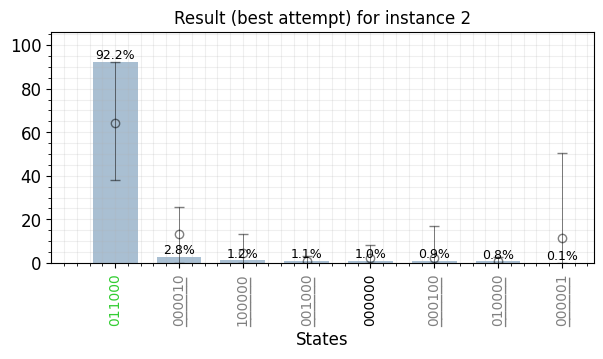

Result saved in:
random_parameters_2025-01-30@09h03m50s/dim6_mail2_all1_random_p3_20ra_k0.167_BOUNDS[0,2pi]x[-220,220]_pars0[0,2pi]x[-220,220].csv
random_parameters_2025-01-30@09h03m50s/dim6_mail2_all1_random_p3_20ra_k0.167_BOUNDS[0,2pi]x[-220,220]_pars0[0,2pi]x[-220,220]_data.txt

TOTAL ELAPSED TIME: 24.834120062987008 minutes.


In [18]:
current_datetime = datetime.now().strftime("%Y-%m-%d@%Hh%Mm%Ss")

# Create a  directory where to collect files
folder_path = f"random_parameters_{current_datetime}"
os.makedirs(folder_path, exist_ok=True)

# Run QAOA+ for every instance.
for instance in chosen_instances:
    if chosen_k!= 1:
        h = k_dict[chosen_k][instance-1]
    else:
        h = 1
    print("*"*50)
    print(f"Instance {instance} with h = {h}\n")

    FILENAME_list = [] # list of .csv containing the final histograms data.
    DATA_FILENAME_list = [] # list of .txt containing metadata such as energies, betas, gammas.

    
    # Define the instance.
    U, subsets_dict = define_instance(n, instance, verbose=False)
    subsets = list(subsets_dict.values())
    _, _, _, _, EXACT_COVERS = find_spectrum(U, subsets_dict, n, h)
    MEC = [state for state in EXACT_COVERS if state.count("1") == min([x.count("1")  for x in EXACT_COVERS])]
    
    
    # Plot states vs energy.
    show_spectrum(n, instance, h, fontsize=10)

    
    # Choose the initialization.
    if init_string == 'all1':
        # Only "1"-states.
        init_name = ["".join(elem) for elem in distinct_permutations('0'*(n-1) + '1')]

    elif init_string == 'all0':
        init_name = ["000000"]
        
      
    # Prepare the cost and mixing circuit.
    constant, hamiltonian, qc_cost = build_cost_circuit(n, instance, h, verbose=False)
    qc_mixing = build_mixing_circuit(n, instance, verbose=False)    
    qc_initial, check_counts  = build_initialization_circuit(n, instance, init_name, verbose=False)
    
    # # Check that initialization was correct.
    # plot_histogram(check_counts, ax=plt.subplots()[1], title="Initialization check", color='k')
    # plt.show(block=False) # don't stop execution
    
    
    # Set initial angles.
    gamma_bound = find_gamma_bound(n, instance, h, verbose=False)
    
    beta_0 = (0, 2*np.pi)
    gamma_0 =  (-gamma_bound, gamma_bound)
    string_0 = f"[0,2pi]x[-{gamma_bound},{gamma_bound}]"
    
    bnds_beta = (0, 2*np.pi)
    bnds_gamma = (-gamma_bound, gamma_bound)
    bnds_string = f"[0,2pi]x[-{gamma_bound},{gamma_bound}]"
    

    # Build files' names.
    header = f"dim{n}_mail{instance}_{init_string}" \
           + f"_random_p{p}_{random_attempts}ra_k{h}" \
           + f"_BOUNDS{bnds_string}_pars0{string_0}"

    FILENAME = os.path.join(folder_path, header + f".csv")
    DATA_FILENAME = os.path.join(folder_path, header + f"_data.txt")

    FILENAME_list.append(FILENAME)
    DATA_FILENAME_list.append(DATA_FILENAME)
    
    
    # Record the details of each attempt in a file.
    with open(DATA_FILENAME, 'a') as DATA_FILE:
        write_params_on_file(DATA_FILE, params) # Write global parameters
        
        E_best = 100
        TOTAL_start_time = time.time()
    
        for attempt in range(1,random_attempts+1):                           
            print(f"\n---------- {attempt}/{random_attempts} random_attempts -----------\n")
            DATA_FILE.write(f"\n---------- {attempt}/{random_attempts} random_attempts -----------\n")
            
            # Build QAOAAnsatz.
            cost_vs_iteration = [] # to save (and plot) iterations
            ansatz = QAOAAnsatz(qc_cost, 
                                mixer_operator=qc_mixing, 
                                initial_state=qc_initial, 
                                reps=p, name='QAOA+')

            
            # Generate a pass manager without providing a backend.
            pm = generate_preset_pass_manager(optimization_level=3)
            ansatz_isa = pm.run(ansatz)
            hamiltonian_isa = hamiltonian.apply_layout(ansatz_isa.layout)
        
            estimator = StatevectorEstimator()
            sampler = StatevectorSampler()

            
            # *************************  FIND OPTIMAL ANGLES  ***************************
            # *************************     THROUGH QAOA+     ***************************
            
            # Set initial angles and angles'bounds.
            pars_0 = [random.uniform(*beta_0) for _ in range(p)] + \
                     [random.uniform(*gamma_0) for _ in range(p)]  
            bnds = [bnds_beta]*p + [bnds_gamma]*p
            
            print(f"pars_0 = {pars_0}")
            print(f"bnds = {bnds}\n")
            
            
            # Do the minimization.
            result = minimize(cost_func, # change cost_func -> cost_func_plot to plot iterations
                              pars_0, bounds=bnds, 
                              args=(ansatz_isa, hamiltonian_isa, estimator), 
                              method="Nelder-Mead", 
                              options={"disp": True, "maxiter": 1200, "maxfev": 1200}, tol=1e-4)

            
            # Works only if you chose cost_func_plot.
            if cost_vs_iteration != []:
                plt.figure()
                plt.plot(cost_vs_iteration) 
                plt.xlabel("Iteration")
                plt.ylabel("Cost")
                plt.show()
            
            
            # Minimum energy reached with minimization.
            E_min = result.fun + constant
            print(f"E_min = result.fun + constant = {E_min}")
            print(f"E_min = result.fun = {result.fun}")
            DATA_FILE.write(f"\nE_min = {E_min}")
            
            
            # Optimal parameters (betas, gammas) found.
            betas = list(result.x[:p])
            gammas = list(result.x[p:])
            print(f"\nOptimal parameters: betas, gammas = {betas}, {gammas}")
            DATA_FILE.write(f'\nE_min\'s parameters: betas = {betas}, gammas = {gammas}\n')

            
            # Update the best attempt.
            if E_min < E_best:
                    E_best = E_min
                    best_attempt = attempt
                    print("--> ***UPDATING THE BEST ATTEMPT***\n")
            else:
                print("--> ***NOT UPDATING THE BEST ATTEMPT***\n")
        
                    
            # ****************************  RUN THE CIRCUIT  ******************************
            # ************************ WITH OPTIMAL PARAMETERS ****************************
            
            # Assign to the previously created ansatz the 2p parameters found.
            pars = betas + gammas 
            qc = ansatz.assign_parameters(pars)
            qc.measure_all() # add a measurement
            
            # Run this circuit.
            qc_isa = pm.run(qc)
            output = sampler.run([qc_isa], shots=1024).result()
            samp_dist = output[0].data.meas.get_counts()
       
            
            # ****************************  POST PROCESS  **********************************
            # *********************** AND SAVE THE OUTPUT HISTOGRAM ************************
            
            # Create a dataframe from the sampling results.
            df = pd.DataFrame(samp_dist.items(), columns=['states', 'counts'])

            # Remove ancillary bits.
            num_ancillas = get_circuit_parameters(subsets, verbose=False)[2]
            df['states'] = df['states'].apply(lambda x: x[num_ancillas:]) 

            # Invert the bit order for the states (e.g., convert "01101" to "10110").
            df['states'] = df['states'].apply(lambda s: str(s)[::-1])  # Invertiamo l'ordine dei bit
            
            # After removing the ancillary bits, we aggregate counts by state.
            df = df.groupby(['states']).sum().reset_index()
            
            # Sort in decreasing order.
            df = df.sort_values('counts', ascending=False) 
            
            # Rename the "counts" column to include attempt details.
            df.columns = ['states', f'counts_p{p}_{attempt}of{random_attempts}']
            
            # Merge the current attempt dataframe with previously built dataframes.
            if attempt == 1:
                df_all_attempts = df
            else:
                df_all_attempts = pd.merge(df_all_attempts, df, on="states", how="outer")    
    
        
    
        # Save to .csv the global dataframe.
        df_all_attempts.to_csv(FILENAME, index=False)
        
        
        # Plot the best attempt (minimum energy), with error bars
        # representing other attempts in the global dataframe.
        plot_histogram_of_best_column(df_all_attempts, 
                                      f'counts_p{p}_{best_attempt}of{random_attempts}', 
                                      EXACT_COVERS, init_name,
                                      fontsize=12, title=f"Result (best attempt) for instance {instance}")
        
        
        DATA_FILE.write("\n*******************************")
        DATA_FILE.write(f"\nAttempt that reached the best result with E_min = {E_best} is #{best_attempt} ")
        DATA_FILE.write(f"\nTOTAL ELAPSED TIME: {(time.time() - TOTAL_start_time)/60} minutes.\n")
        print(f"Result saved in:\n{FILENAME}\n{DATA_FILENAME}")
        print(f"\nTOTAL ELAPSED TIME: {(time.time() - TOTAL_start_time)/60} minutes.")

## (Optional) Draw the latest instance QAOA circuit

Instance #2


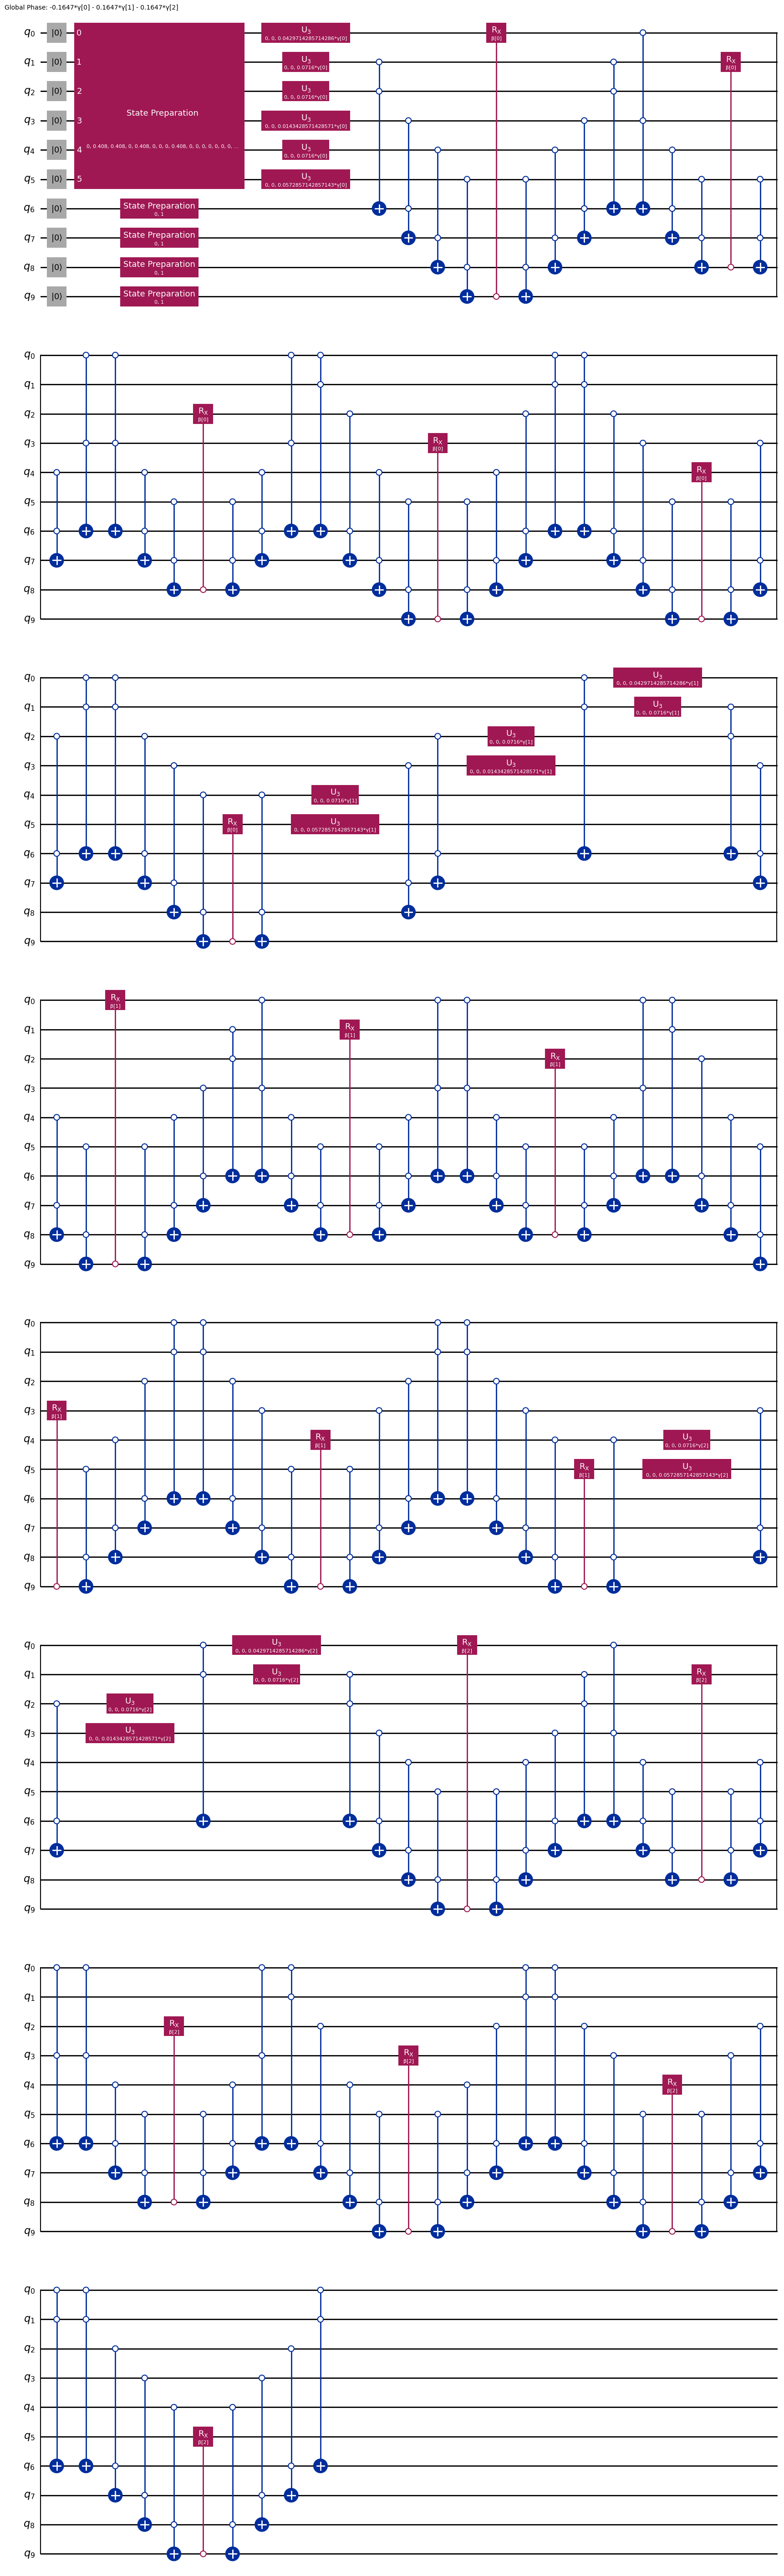

In [19]:
print(f"Instance #{instance}")
ansatz.decompose(reps=2).draw("mpl")

## Read from File
Plot the results of all chosen instances for which QAOA has been computed or plot results from a previous run.

The `find_files_containing_string` function will search for `.csv` and `.txt` files in the selected `path`. If provided, it will also search for files that contain a specific string of text.

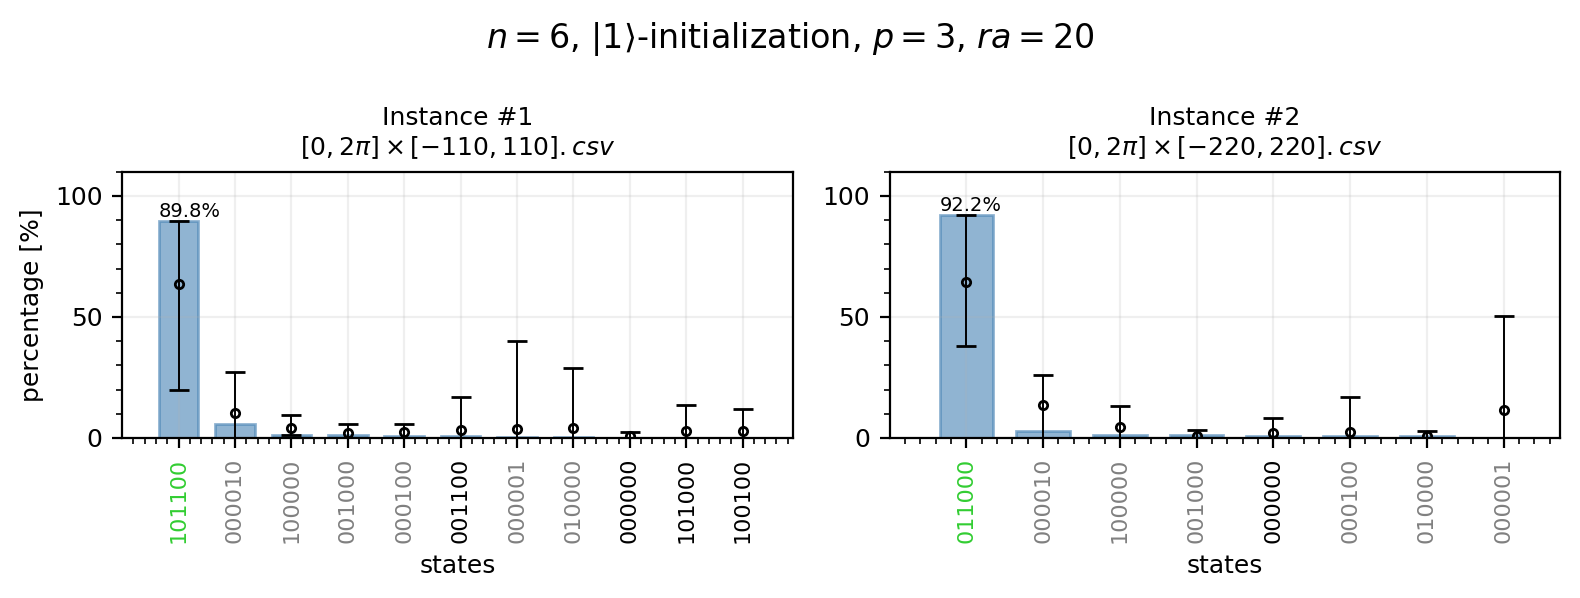

In [20]:
# Uncomment this line to plot data from an existing directory
# folder_path = "random_parameters_2025-01-30@09h03m50s"

# Find the files that contain every string in 'substrings'.
FILENAME_list, DATA_FILENAME_list = find_files_containing_string(path= f"./{folder_path}/")

# Get the number of files collected.
num_files = len(FILENAME_list)

if num_files>1:
    plot_list_of_files(FILENAME_list, DATA_FILENAME_list, 
                       colorchosen="steelblue", alpha=0.6,
                       init_name="all1",
                       dont_show_in_title=["i", "k"], 
                       dont_show_in_titles=["n", "p", "ra", "k", "init"], 
                       figsize=(8,num_files+1),
                       dpi=200, N=9) # figsize=(10, 13), dpi=300, N=12 for latex figures
else:
    plot_file(FILENAME_list[0], DATA_FILENAME_list[0], 
              colorchosen='indigo', alpha=0.4,
              dont_show_in_title = [], 
              figsize=(10,4), dpi=200, N=10)